In [4]:
import numpy as np 
import pandas as pd
import json
import calendar

import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import auc


%matplotlib inline

# Part 1 : Exploratory Data Analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location.<br> Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time<br> series of login counts in ways that best characterize the underlying patterns of the demand.<br> Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

### Solutions: 

I resampled the login counts for every 15 minutes and plotted as a function of time. <br> The data follow a systematic pattern. More detail analysis of the login counts per hour, day, month, shows that the rider counts <br>
follow very nice pattern. Riders counts are more in the weekend. There are two peaks on the login counts vs hours graph which implies that most logins are occurred in the night tiem and during the business hours. Minimum logins are found during the office opening and closing hours. All possible time series plots are presented below. 

In [5]:
# Loading the given datafile. 
df = pd.read_json('logins.json')

In [6]:
# Creating new column for counting each logins
df['counts'] = 1

# The samples are resampled with the 15 minutes interval 
df_agg = df.set_index('login_time').resample('15min').sum()

df_agg.reset_index(inplace=True)

In [7]:
# Creating separate columns for year, month, day, hour, dayofweek and dayofyear
df_agg['year'] = df_agg.login_time.dt.year
df_agg['month'] = df_agg.login_time.dt.month
df_agg['day'] = df_agg.login_time.dt.day
df_agg['hour'] = df_agg.login_time.dt.hour
df_agg['dayofweek'] = df_agg.login_time.dt.dayofweek
df_agg['dayofyear'] = df_agg.login_time.dt.dayofyear
df_agg['dayofweek_name'] = df_agg.login_time.dt.weekday_name
df_agg['month_name'] = df_agg['month'].apply(lambda x: calendar.month_abbr[x])


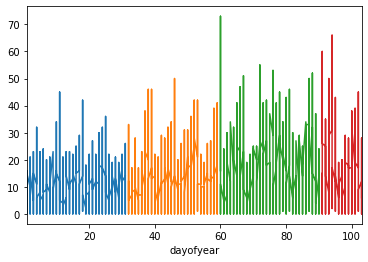

In [8]:
fig, ax = plt.subplots()
for i, j in enumerate(df_agg['month'].unique()):
    df_agg[df_agg['month']==j][['dayofyear', 'counts']].set_index('dayofyear').plot(ax=ax, legend=False)

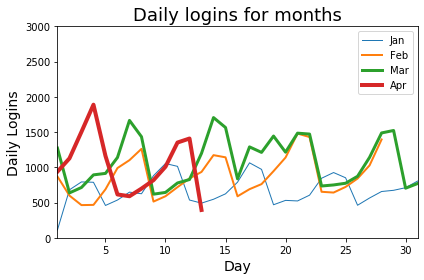

In [9]:
for i, x in enumerate(df_agg['month_name'].unique()):
    df_m = df_agg[df_agg['month_name']==x].groupby('day').sum()['counts']
    df_m.plot(label=x, linewidth=i+1)
    plt.legend()
plt.title('Daily logins for months', fontsize=18)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Daily Logins', fontsize=14)
plt.ylim(0, 3000)
plt.tight_layout()

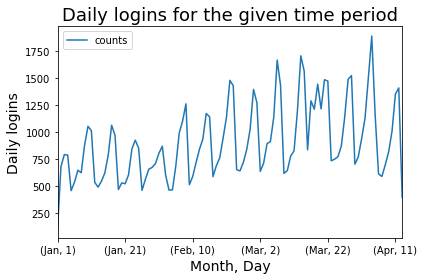

In [10]:
x = df_agg.groupby(['month', 'day']).sum()['counts'].reset_index()
x['month'] = x.month.apply(lambda x: calendar.month_abbr[x])
x.set_index(['month', 'day']).plot()
plt.xlabel('Month, Day', fontsize=14)
plt.ylabel('Daily logins', fontsize=14)
plt.title('Daily logins for the given time period', fontsize=18)
plt.tight_layout()

From the daily aggregate logins plotted against day, we found the excellent pattern <br> with the repeated minima and maxima with frequency of approximately equal to 5 days.<br> We also found that the amplitude of the pattern increases after month 2.<br> The daily logins are increasing every months. 

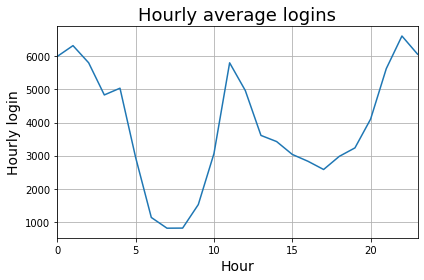

In [11]:
df_agg.groupby('hour').sum()['counts'].plot()
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Hourly login', fontsize=14)
plt.title('Hourly average logins', fontsize=18)
plt.grid()
plt.tight_layout()

The hourly pattern shows that there are two minima at 8am and 5pm.<br> This suggests the hourly minimum number of logins at the
office opening and closing hours. <br> Maximum hourly logins were observed at the midnight and at the midday.

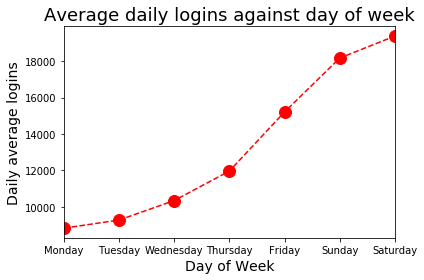

In [12]:
df_dayofweek = df_agg.groupby('dayofweek_name').sum()['counts']
df_dayofweek.sort_values().plot(marker='o',
                  color='r',
                  linestyle='--',
                  markersize=12)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Daily average logins', fontsize=14)
plt.title('Average daily logins against day of week', fontsize=18)
plt.tight_layout()

From the graph of average daily logins on each day of week,<br> 
one can easily explain the oscillating graph of daily average <br> 
against day of year with frequency of 5 days. <br>
The number of logins increase sharp linearly and become highest at the weekends.  

'From the above observations on the effect of the various featrues such as year, month, day of month, day of year, day of week, and hours, we conclude that all the features except have significant effect on the login counts.'

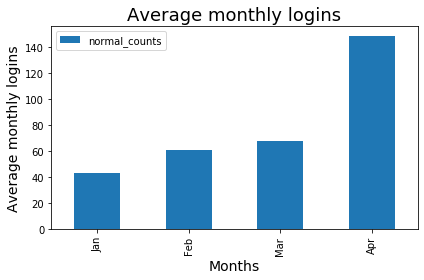

In [19]:
xx = x.groupby('month').sum()
xx['normal_counts'] = xx['counts']/xx['day']

xx_month = xx.reset_index().sort_values(['normal_counts'], ascending=True)
xx_month.set_index('month').drop(['day', 'counts'], axis=1).plot(kind='bar')
plt.xlabel('Months', fontsize=14)
plt.ylabel('Average monthly logins', fontsize=14)
plt.title('Average monthly logins', fontsize=18)
plt.tight_layout()
'''From the above observations on the effect of the various featrues such as year, month, day of month, day of year, day of week, and hours, we conclude that all the features except have significant effect on the login counts.'''

# Part 2 : Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, <br>Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. <br>On weekends, there is reasonable activity in both cities.<br>
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. <br>The Ultimate managers of city operations for the two cities have proposed an experiment to <br> encourage driver partners to be available in both cities, by reimbursing all toll costs.<br>
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities,<br> and why would you choose this metric?<br>
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change <br> in relation to the key measure of success. Please provide details on:<br>
    a. how you will implement the experiment<br>
    b. what statistical test(s) you will conduct to verify the significance of the
    observation<br>
    c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

### Solutions:

1. Choice of metric:<br>
After applying new rule, the overall revenue will measure the success or failure. If the revenue increases,<br>
the policy becomes successful. Threfore, the metric of interest is: <br>
(average income after new rule - total costs on reimburse) - average income before the new rule
<br>

2. Experiment:<br>
    a. We observe the data for months right before applying the new rule and after new rule.<br>
From the data set, we filter equal number of observations. Selected observations were not <br>
for the days when both cities were equally live. We apply bootstrap experiments to observe the actual <br> 
statistical parameters.

    b. We set the null hypothesis as:<br>
(average income after new rule - total costs on reimburse) - (average income before the new rule) = 0<br>
i.e. applying new rule is not significantly different than before.<br>
We calculate the distributions of mean and std using central limit theorem and calculate the p-value for the <br> difference of means of two sets. We set the confidence level (e.g. 95%). <br>If the calculated p-value is greater than 0.05, then we accept the null hypothesis otherwise we reject it.<br>

    c. If the calculated p-value is less than 0.05, then we accept the alternative <br>
    hypothesis, i.e. the implementation of new policy is stastitically significant. <br>
    We conclude the success of the policy and recommend to continue the policy.<br>
    We always keep in mind other factors affecting the regular businesses of the cities <br>
    such as federal and local holidays, and seasonal environments. 


# Part 3 : Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample <br>dataset of a cohort of users who signed up for an Ultimate account in
January 2014.<br> The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.<br>
We would like you to use this data set to help understand what factors are the best predictors for retention,<br> and offer suggestions to operationalize those insights to help Ultimate.<br>
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset.<br> Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.<br>
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis<br> (a few sentences/plots describing your approach will suffice). <br>What fraction of the observed users were retained?<br>
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system.<br> Discuss why you chose your approach, what alternatives you considered, and any concerns you have.<br> How valid is your model? Include any key indicators of model performance.<br>
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).
#### Data description
● city: city this user signed up in<br>
● phone: primary device for this user<br>
● signup_date: date of account registration; in the form ‘YYYYMMDD’<br>
● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’<br>
● avg_dist: the average distance in miles per trip taken in the first 30 days after signup<br>
● avg_rating_by_driver: the rider’s average rating over all of their trips<br>
● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips<br>
● surge_pct: the percent of trips taken with surge multiplier > 1<br>
● avg_surge: The average surge multiplier over all of this user’s trips<br>
● trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up<br>
● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise<br>
● weekday_pct: the percent of the user’s trips occurring during a weekday<br>

### Solutions:

## 1. Cleaning, EDA and Visualization:

In [51]:
with open('ultimate_data_challenge.json', encoding='utf-8') as data_file:
    data = pd.DataFrame(json.loads(data_file.read()))

# Converting the date columns to datetime format
data['signup_date'] = pd.to_datetime(data['signup_date'])
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'])

# Creating cutoff date after 6 months from sign up date.
data['cutoff'] = data['signup_date'] + pd.DateOffset(months=6)
# User active 'days' before cutoff date.
data['l_to_c'] = data['cutoff'] - data['last_trip_date']
# Converting to the days:
data['l_to_c'] = data['l_to_c']/np.timedelta64(1, 'D')
# Setting all target as 0: 
data['target'] = 0
# We apply condition and selected entries set to 1, otherwise 0
data['target'].where((data['l_to_c'] > 30), 1, inplace=True)
data['target'].where((data['l_to_c'] <= 30), 0, inplace=True)
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,cutoff,l_to_c,target
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,2014-07-25,38.0,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2014-07-29,85.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2014-07-06,180.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2014-07-10,11.0,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,2014-07-27,134.0,0


### Users retained as a function of Catgorical variables:

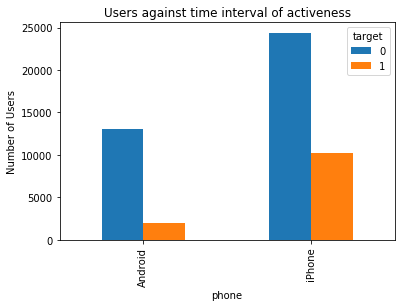

In [52]:
pd.crosstab(data['phone'], data['target']).plot(kind='bar')
plt.ylabel('Number of Users')
plt.title('Users against time interval of activeness')
plt.show()

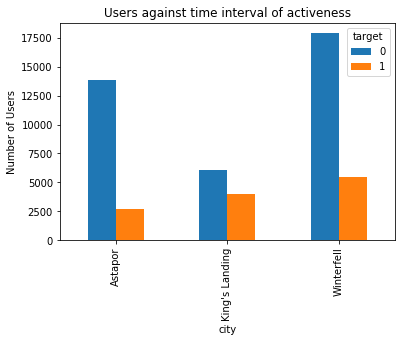

In [53]:
pd.crosstab(data['city'], data['target']).plot(kind='bar', stacked=False)
plt.ylabel('Number of Users')
plt.title('Users against time interval of activeness')
plt.show()

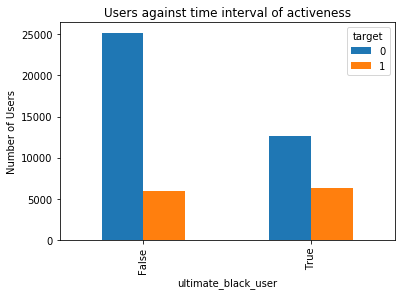

In [54]:
pd.crosstab(data['ultimate_black_user'], data['target']).plot(kind='bar')
plt.ylabel('Number of Users')
plt.title('Users against time interval of activeness')
plt.show()

### Retention fraction against their signup days

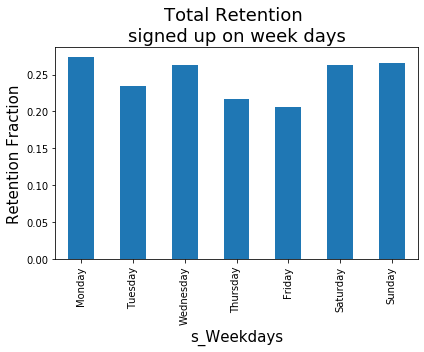

In [55]:
data['s_dayofweek'] = data['signup_date'].dt.dayofweek
daysdict = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

data_dayofweek = data.groupby('s_dayofweek').mean()['target'].reset_index()
data_dayofweek['s_dayofweek'] = data_dayofweek.s_dayofweek.map(daysdict)
data['s_dayofweek'] = data['s_dayofweek'].map(daysdict)
fig, ax = plt.subplots(figsize=(6, 5))
data_dayofweek.set_index('s_dayofweek').plot(kind='bar', legend=False, ax=ax)
plt.title('Total Retention \nsigned up on week days', fontsize=18)
plt.ylabel('Retention Fraction', fontsize=15)
plt.xlabel('s_Weekdays',fontsize=15)
plt.tight_layout()

### Effect of rating 'by' and 'of' the drivers on retention:

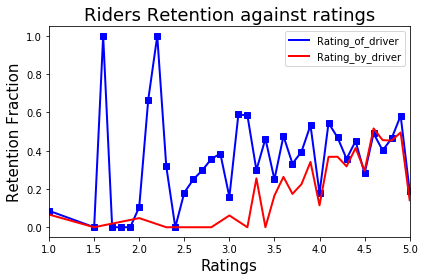

In [56]:
drod = data.groupby('avg_rating_of_driver').mean().target
drod.plot(label='Rating_of_driver',
          marker='s',
          linewidth=2, color='b',
          legend=True)
drbd = data.groupby('avg_rating_by_driver').mean().target
drbd.plot(label='Rating_by_driver',
          linewidth=2, color='r',
          legend=True)
plt.xlabel('Ratings', fontsize=15)
plt.ylabel('Retention Fraction', fontsize=15)
plt.title('Riders Retention against ratings', fontsize=18)
plt.tight_layout()

### Average surge and Surge%:

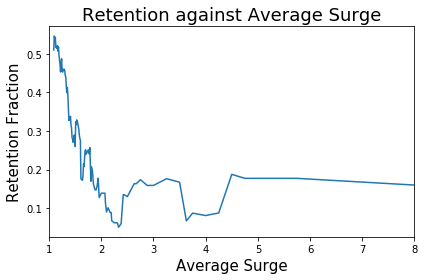

In [57]:
data.groupby('avg_surge').mean().target.rolling(10).mean().plot()
plt.xlabel('Average Surge', fontsize=15)
plt.ylabel('Retention Fraction', fontsize=15)
plt.title('Retention against Average Surge', fontsize=18)
plt.tight_layout()

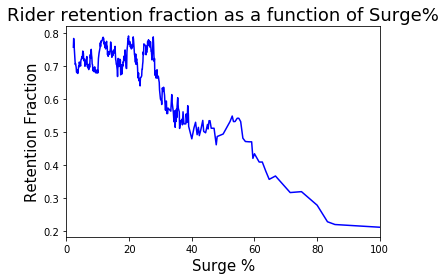

In [58]:
data.groupby('surge_pct').mean().target.rolling(20).mean().plot(color='blue')
plt.xlabel('Surge %', fontsize=15)
plt.ylabel('Retention Fraction', fontsize=15)
plt.title('Rider retention fraction as a function of Surge%', fontsize=18)
plt.tight_layout()

### Weekdays % of user trips:

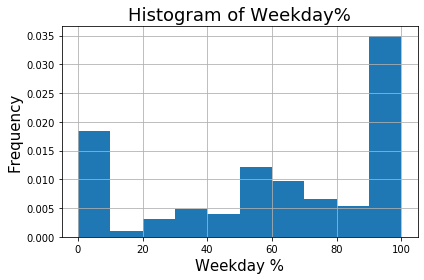

In [59]:
data['weekday_pct'].hist(density=True)
plt.title('Histogram of Weekday%', fontsize=18)
plt.xlabel('Weekday %', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.tight_layout()

### Most of the retained users belong to short trip riders

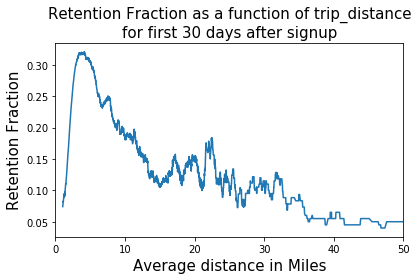

In [60]:
data.groupby('avg_dist').mean().target.rolling(100).mean().plot()
plt.xlim(0, 50)
plt.xlabel('Average distance in Miles', fontsize=15)
plt.ylabel('Retention Fraction', fontsize=15)
plt.title('Retention Fraction as a function of trip_distance\nfor first 30 days after signup', fontsize=15)
plt.tight_layout()

From the observation of the above exploratory data analysis, <br> 
we found that all the given variables are important to predict the <br> 
rider retention. Therefore, We will keep all variables except the<br>
'last trip date' as the features . We extracted the binary target variable<br>
from the 'last trip date' variable. 

## Missing Data

We see that some of the average rating (of driver and by driver) data are missing.<br>
Information of type of phone also missing. We assume that the rider retention is not <br> 
influenced much by the type of phone used. Therefore, We impute all the missing places <br>
for phone column randomly by using bfill method. However, rating of driver and by driver<br> 
is most powerful feature to predict the riders retention. Therefore, we impute the missed <br>
data for ratings columns by observing the retention class. From the graph of retention <br>
fraction vs ratings, we see that the retention fraction for rating less than 3 is almost zero.<br>
Therefore, we impute the missed place by 4.0 if retention is 1 and by 0 if retention is 0.

In [61]:
data['phone'].fillna('iPhone', inplace=True)

In [62]:
m1 = data.target == 1
m2 = data.target == 0
m3 = 'avg_rating_of_driver'
m4 = 'avg_rating_by_driver'
data.loc[m1, [m3, m4]] = data.loc[m1, [m3, m4]].fillna(4.0)
data.loc[m2, [m3, m4]] = data.loc[m2, [m3, m4]].fillna(0.0)

### Feature Engineering:

In [64]:
# We drop the irrelevant features:
new_df = data.drop(['s_dayofweek', 'signup_date',
                    'last_trip_date',
                    'cutoff', 'l_to_c',
                    'target'], axis=1)
# Converting the True and False to 0 & 1
new_df['ultimate_black_user'] = new_df['ultimate_black_user']*1

# Filtering the categorical and numerical features
cat_cols = new_df.select_dtypes('object', 'bool').columns
numeric_cols = [x for x in list(new_df.columns) if x not in list(cat_cols)]

# Normalizing the numeric features and 
# converting the categorical features to numeric by one hot encoding.  
scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(new_df[numeric_cols])
X_numeric = pd.DataFrame(scaled_numeric, columns=numeric_cols)
X_dummies = pd.get_dummies(new_df[cat_cols])
# Fetarues and Target data ready for machine learning models:
X = pd.concat([X_numeric, X_dummies], axis=1)
y = data['target']


<br>
<br>
<br> 


## 2. Building Predictive Models:

<br>
<br> 

### Functions Used for predictive model: 

In [65]:
def training_output(X_train, y_train, clf):
    '''This function calculates the train and test scores'''
    train_sizes, train_scores, test_scores = \
        learning_curve(estimator=clf,
                       X=X_train,
                       y=y_train,
                       train_sizes=np.linspace(0.1, 1.0, 5),
                       cv=5,
                       scoring = scorer,
                       n_jobs=-1, shuffle=True)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    return train_sizes, train_mean, train_std, test_mean, test_std

In [66]:
def plot_learning_curve(train_size, train_m, train_std, test_m, test_std):
    ''' This function uses the mean and std of train and test
    scores and plots the learning curve:'''
    
    _ = plt.figure(figsize=(7,5))
    _ = plt.plot(train_size, train_m, 
                 color='r', marker='o', 
                 markersize=5, label='training AUC')

    _ = plt.fill_between(train_size, 
                         train_m + train_std,
                         train_m - train_std, 
                         alpha=0.15, color='r')

    _ = plt.plot(train_size, test_m, 
                 color='b', linestyle='--', 
                 marker='s', markersize=5, 
                 label='validation AUC')

    _ = plt.fill_between(train_size, 
                         test_m + test_std,
                         test_m - test_std, 
                         alpha=0.15, color='b')

    _ = plt.title('Learning curve')
    _ = plt.xlabel('Number of training samples', fontsize=14)
    _ = plt.ylabel('AUC score', fontsize=14)
    _ = plt.legend(loc='lower right', fontsize=14)
    _ = plt.ylim([min(test_m) - 0.025, max(train_m) + 0.025])
    _ = plt.tight_layout()
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)
    
    return plt.show()

In [67]:
def validation_output(X_train, y_train, clf, param_range, param_name):
    '''This function calculates the validation scores'''
    train_scores, test_scores = validation_curve(estimator=clf,
                                                 X=X_train,
                                                 y=y_train,
                                                 param_name=param_name,
                                                 param_range=param_range,
                                                 cv=5,
                                                 scoring = scorer)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    return train_mean, train_std, test_mean, test_std

In [68]:
def plot_validation_curve(train_m, train_std, test_m,
                          test_std, param_range,
                          param_name, alpha1=0.15,
                          alpha2=0.15):
    '''This function plots the validation scores 
    as a function of selected param: '''
    
    _ = plt.figure(figsize=(7,5))
    _ = plt.plot(param_range, train_m, 
                 color='r', marker='o', 
                 markersize=5, label='training AUC')

    _ = plt.fill_between(param_range, 
                         train_m + train_std,
                         train_m - train_std, 
                         alpha=alpha1, color='r')

    _ = plt.plot(param_range, test_m, 
                 color='g', linestyle='--', 
                 marker='s', markersize=5, 
                 label='validation AUC')

    _ = plt.fill_between(param_range, 
                         test_m + test_std,
                         test_m - test_std, 
                         alpha=alpha2, color='g')

    _ = plt.title('Validation curve')
    _ = plt.xscale('log')
    _ = plt.xlabel('Parameter: '+str(param_name), fontsize=14)
    _ = plt.ylabel('AUC score', fontsize=14)
    _ = plt.legend(loc='best', fontsize=14)
    _ = plt.ylim([min(test_m) - 0.025, max(train_m) + 0.025])
    _ = plt.tight_layout()
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)
    
    return plt.show()

In [69]:
def plot_ROC(y_tr, y_ts, y_pred_tr, y_pred_ts):
    '''This function plots the ROC curve by using 
    y_train, y_test and predicted train and test data. 
    It demands importing 'auc' from the sklearn.metrics'''
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_true=y_tr, y_score=y_pred_tr)
    fpr_ts, tpr_ts, thresholds_ts = roc_curve(y_true=y_ts, y_score=y_pred_ts)

    roc_auc_tr = auc(x=fpr_tr, y=tpr_tr)
    roc_auc_ts = auc(x=fpr_ts, y=tpr_ts)

    _ = plt.figure(figsize=(7,5))
    _ = plt.plot(fpr_tr, tpr_tr, color='b', linestyle='-', 
                 label='%s (auc = %0.3f)' % ('Train', roc_auc_tr))
    _ = plt.plot(fpr_ts, tpr_ts, color='r', linestyle='-', 
                 label='%s (auc = %0.3f)' % ('Test', roc_auc_ts))
    _ = plt.plot([0, 1], [0, 1], linestyle='--', linewidth=2)

    _ = plt.legend(loc='best', fontsize = 14)
    _ = plt.xlim([0., 1.])
    _ = plt.ylim([0., 1.])
    _ = plt.xlabel('False Positive Rate', fontsize = 14)
    _ = plt.ylabel('True Positive Rate', fontsize = 14)
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)
    _ = plt.tight_layout()
    _ = plt.title('ROC curve', fontsize = 14)
    
    return plt.show()

In [70]:
def plot_precision_recall_curve(y_train, y_test, train_pred, test_pred):
    '''This function plots the precision-recall curve.
    It requires two modules to be imported: 
    (a) average_precision and (b) precision_recall_cruve 
    from sklearn.metrics.
    Inputs 'train_pred' and 'test_pred' are output of clf.predict_proba.'''
    
    average_precision = average_precision_score(y_true = y_test, 
                                                y_score = test_pred)
    train_precision, train_recall, train_threshold = \
        precision_recall_curve(y_true=y_train, probas_pred=train_pred)
    test_precision, test_recall, test_threshold = \
        precision_recall_curve(y_true=y_test, probas_pred=test_pred)

    _ = plt.figure(figsize=(7,5))
    _ = plt.plot(train_recall,
                 train_precision,
                 color='b', 
                 linestyle='-', 
                 label='%s' % ('Training'))
    _ = plt.plot(test_recall,
                 test_precision,
                 color='r', 
                 linestyle='-', 
                 label='%s' % ('Testing'))
    _ = plt.legend(loc='best', fontsize = 14)
    _ = plt.xlim([0., 1.])
    _ = plt.ylim([0., 1.])
    _ = plt.xlabel('Recall', fontsize = 14)
    _ = plt.ylabel('Precision', fontsize = 14)
    _ = plt.tight_layout()
    _ = plt.title('Precision vs Recall curve: '
                   'AP={0:0.2f}'.format(average_precision), 
                  fontsize = 14)
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)
    
    return plt.show()


## Logistic Regression Classifier:

In [71]:
# Splitting the data into train and test set:
X_train, X_test, y_train, y_test = \
                train_test_split(X, y,
                                 test_size= 0.3,
                                 random_state=33)

In [72]:
# Defining the model:
logreg = LogisticRegression(C=0.01, solver='liblinear',
                            penalty='l2',
                            class_weight = 'balanced',
                            max_iter=700)
logreg.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=700, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [73]:
# Predicting the rider retention using test set:
train_pred = logreg.predict(X_train)
test_pred = logreg.predict(X_test)

In [74]:
# Accuracy Score:
print('Training Accuracy: ', round(accuracy_score(y_train, train_pred), 2))
print('Testing Accuracy: ', round(accuracy_score(y_test, test_pred), 2))

Training Accuracy:  0.66
Testing Accuracy:  0.65


### Validation Curve

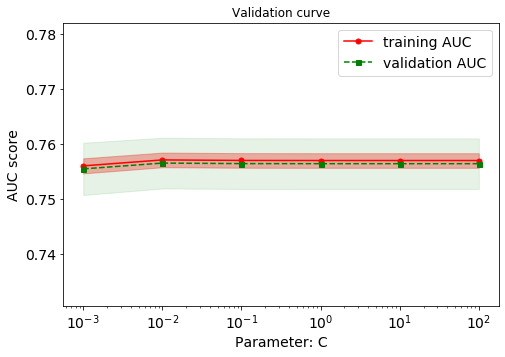

In [75]:
scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba = True)
C = [0.001, 0.01, 0.1, 1., 10., 100.]
train_m, train_std, test_m, test_std = validation_output(X_train, y_train, logreg, C, 'C')
plot_validation_curve(train_m, train_std, test_m, test_std,
                      C, 'C', alpha1=0.3, alpha2=0.1)

### Hyperparamter Tuning:

In [78]:
solvers = ['lbfgs', 'liblinear', 'sag']
max_iter = [700]
C = [0.001, 0.01, 0.1]
param_grid = [{'C': C, 'solver': solvers, 'max_iter': max_iter}]

gs = GridSearchCV(estimator=logreg, 
                  param_grid=param_grid, 
                  scoring=scorer, 
                  cv=5,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
print('Best AUC score on training data: ' + str(gs.best_score_))
print('Best parameters: ' + str(gs.best_params_))

Best AUC score on training data: 0.7565128946413786
Best parameters: {'C': 0.01, 'max_iter': 700, 'solver': 'liblinear'}


In [79]:
best_clf = gs.best_estimator_
best_clf.fit(X_train, y_train)
print('AUC score on test data: %.3f' 
      %roc_auc_score(y_true = y_test, 
                     y_score = best_clf.predict_proba(X_test)[:,1]))

AUC score on test data: 0.744


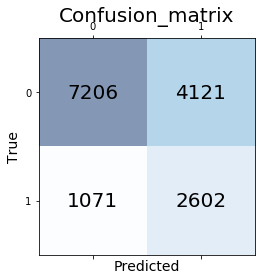

In [80]:
# Plotting the confusion Matrix
y_pred = best_clf.predict(X_test)
confmat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center', fontsize=20)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion_matrix', fontsize=20)
plt.tight_layout()
plt.show()

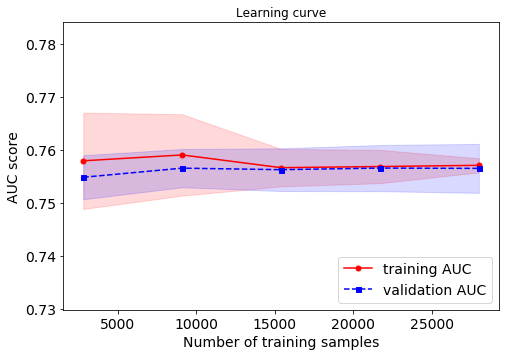

In [81]:
train_size, train_m, train_std, test_m, test_std = \
            training_output(X_train,
                            y_train,
                            best_clf)

plot_learning_curve(train_size,
                    train_m,
                    train_std,
                    test_m,
                    test_std)

### Classification Report:

In [82]:
print(classification_report(y_test, y_pred, target_names= ['Not Retained', 'Retained']))

              precision    recall  f1-score   support

Not Retained       0.87      0.64      0.74     11327
    Retained       0.39      0.71      0.50      3673

    accuracy                           0.65     15000
   macro avg       0.63      0.67      0.62     15000
weighted avg       0.75      0.65      0.68     15000



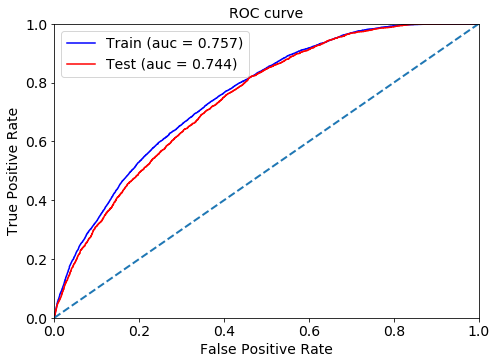

In [83]:
pred_proba_train = best_clf.predict_proba(X_train)[:, 1]
pred_proba_test = best_clf.predict_proba(X_test)[:, 1]
plot_ROC(y_train, y_test, pred_proba_train, pred_proba_test)

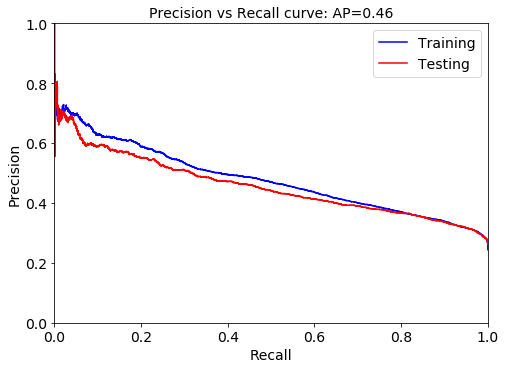

In [84]:
plot_precision_recall_curve(y_train, y_test, pred_proba_train, pred_proba_test)

#### Q: Discuss why you chose your approach, what alternatives you considered, and any concerns you have. <br> How valid is your model? Include any key indicators of model performance.

We see this problem is classification of riders retained or not. Therefore, for such binary classification is<br> logistic regression classification approach. We can apply other classification models too, but as we have <br> enough independent observations with non-colinear features, it fulfils the major assumptions of logistic<br> regression. The validity of the model were observed by calculating precision and recall and plotting in the <br> ROC curve as shown above.

### Feature Importance Using Logit in Statsmodel:

In [85]:
import statsmodels.api as sm
logit = sm.Logit(y_train, X_train)
print(logit.fit().summary())

Optimization terminated successfully.
         Current function value: 0.472254
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                35000
Model:                          Logit   Df Residuals:                    34988
Method:                           MLE   Df Model:                           11
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                  0.1493
Time:                        17:56:32   Log-Likelihood:                -16529.
converged:                       True   LL-Null:                       -19431.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
trips_in_first_30_days     0.3059      0.014     22.451      0.000       0.279      

/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


## 3. Recommendation: 


#### Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

We calculated the logit parameters by using python 'statsmodels' package. The features with p-values < 0.05 are and 
larger 'coef' > 0.15 are: 

#### 1. avg_rating_of_driver
#### 2. ultimate_black_user
#### 3. trips_in_first_30_days


Therefore, to improve the long term rider retention, Ultimate should use its concern on proper rating of the <br> driver, for users with 'ultimate_black_user' and promotional offers in the first 30 days.  